In [1]:
import yaml
from pathlib import Path
import matplotlib.pyplot as plt

from datasets import BCDataDataset, PointsToGaussianHeatmap, PointsToGaussianHeatmapFast
from visualization import overlay_heatmap

import torch

In [2]:
with open("config.yaml", "r") as f:
    cfg = yaml.safe_load(f)


data_root = Path(cfg["paths"]["data_root"])
print(data_root)

/home/yeldos/Istanbul/obsidian_vault/work_AITU/IHC/DATASETS/BCData


In [3]:
heatmap_generator = PointsToGaussianHeatmap(out_hw=(160,160), in_hw=(640,640), sigma=2.0)

In [4]:
dataset = BCDataDataset(root = data_root,
                        split="train",
                        target_transform = heatmap_generator)



In [5]:
import torch.nn.functional as F

@torch.no_grad()
def heatmap_to_points(
    heatmap: torch.Tensor,
    thr: float = 0.3,
    nms_kernel: int = 3,
    topk: int | None = None,
    return_scores: bool = False,
):
    """
    Convert a single heatmap into point coordinates by local-max NMS + threshold.

    Args:
        heatmap: (H, W) tensor (usually after sigmoid, in [0,1]).
        thr: keep peaks with value >= thr.
        nms_kernel: odd int, neighborhood size for local maxima (e.g., 3 or 5).
        topk: if set, keep only topk peaks by score (after NMS+thr).
        return_scores: if True, also return peak scores.

    Returns:
        pts: (N, 2) long tensor with (x, y) coordinates in heatmap pixel space.
        (optional) scores: (N,) tensor with peak values.
    """
    if heatmap.ndim != 2:
        raise ValueError(f"heatmap must be (H,W), got shape {tuple(heatmap.shape)}")
    if nms_kernel % 2 == 0 or nms_kernel < 1:
        raise ValueError("nms_kernel must be an odd positive integer (e.g., 3, 5, 7).")

    H, W = heatmap.shape
    k = nms_kernel
    pad = k // 2

    h = heatmap.unsqueeze(0).unsqueeze(0)  # (1,1,H,W)

    pooled = F.max_pool2d(h, kernel_size=k, stride=1, padding=pad)
    is_peak = (h == pooled) & (h >= thr)

    ys, xs = torch.where(is_peak[0, 0])  # 1D indices
    if xs.numel() == 0:
        pts = torch.zeros((0, 2), dtype=torch.long, device=heatmap.device)
        if return_scores:
            scores = torch.zeros((0,), dtype=heatmap.dtype, device=heatmap.device)
            return pts, scores
        return pts

    scores = heatmap[ys, xs]

    if topk is not None and scores.numel() > topk:
        idx = torch.topk(scores, k=topk, largest=True).indices
        xs, ys, scores = xs[idx], ys[idx], scores[idx]

    pts = torch.stack([xs, ys], dim=1).to(torch.long)  # (N,2) (x,y)

    if return_scores:
        return pts, scores
    return pts

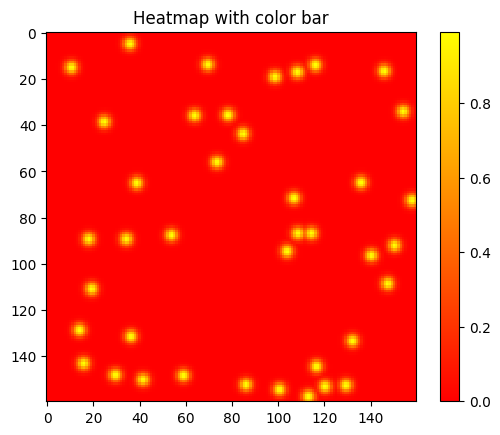

torch.Size([1, 160, 160])


In [12]:
forplot_img, forplot_heatmap, forplot_points = dataset.__getitem__(1)
plt.imshow(forplot_heatmap[0, :,:], cmap='autumn', interpolation='nearest')
plt.colorbar()
plt.title("Heatmap with color bar")
plt.show()

print(forplot_heatmap.shape)
# forplot_img = forplot_img.unsqueeze(0)
# print(forplot_img.shape)

In [23]:
for i in range(-5, 6):
    for j in range(-5, 6):
        if j == 5:
            end = '\n'
        else:
            end = ', '
        print(forplot_heatmap[0, 10+i, 15+j].item(), end=end)

1.9183166841685306e-06, 1.9183166841685306e-06, 1.4939864740881603e-06, 9.061486139216868e-07, 4.2803429778359714e-07, 1.5746502413094277e-07, 4.5114482816188684e-08, 1.0066401934238911e-08, 1.7492783888073404e-09, 2.3673907278976003e-10, 2.4952115026954935e-11
2.1953970644972287e-05, 2.1953970644972287e-05, 1.709777097858023e-05, 1.037032143358374e-05, 4.898593033431098e-06, 1.8020916741079418e-06, 5.163079208614363e-07, 1.1520386777874592e-07, 2.001943144591678e-08, 2.70933542267926e-09, 2.855618519426173e-10
0.0001956736232386902, 0.0001956736232386902, 0.00015239077038131654, 9.242966916644946e-05, 4.3660686060320586e-05, 1.606186924618669e-05, 4.601802629622398e-06, 1.0268008736602496e-06, 1.7843123600869149e-07, 2.414804356476452e-08, 2.545184951685542e-09
0.001358244102448225, 0.001358244102448225, 0.0010578015353530645, 0.0006415891111828387, 0.0003030652296729386, 0.00011149147030664608, 3.194283999619074e-05, 7.127411208784906e-06, 1.238558297700365e-06, 1.676206409229053e-07

In [31]:
forplot_heatmap[0, 87, 108].item()

0.9692332148551941

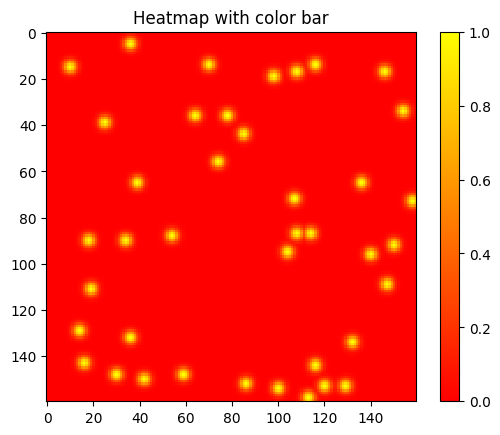

torch.Size([1, 160, 160])


In [7]:
forplot_img, forplot_heatmap, forplot_points = dataset.__getitem__(1)
plt.imshow(forplot_heatmap[0, :,:], cmap='autumn', interpolation='nearest')
plt.colorbar()
plt.title("Heatmap with color bar")
plt.show()

print(forplot_heatmap.shape)
# forplot_img = forplot_img.unsqueeze(0)
# print(forplot_img.shape)

In [17]:
recovered_points = heatmap_to_points(forplot_heatmap[0], return_scores=True)

In [20]:
recovered_points, scores = recovered_points

In [21]:
scores

tensor([0.9922, 0.9692, 0.9692, 0.9922, 0.9617, 0.9617, 0.9845, 0.9845, 0.9617,
        0.9617, 0.9922, 0.9922, 0.9845, 0.9845, 0.9922, 0.9617, 0.9617, 0.9845,
        0.9922, 0.9845, 0.9845, 0.9692, 0.9692, 0.9922, 0.9845, 0.9692, 0.9617,
        0.9692, 0.9617, 0.9845, 0.9845, 0.9617, 0.9617, 0.9845, 0.9922, 0.9922,
        0.9617, 0.9617, 0.9692, 0.9692, 0.9845, 0.9394, 0.9394, 0.9394, 0.9394,
        0.9617, 0.9617, 0.9692, 0.9692, 0.9617, 0.9617, 0.9692, 0.9692, 0.9845,
        0.9845, 0.9394, 0.9394, 0.9394, 0.9394, 0.9692, 0.9692])

In [8]:
import numpy as np

# convert to numpy
rp = recovered_points.detach().cpu().numpy()
fp = forplot_points.detach().cpu().numpy()

# sort by both axes: first by x, then by y
rp_sorted = rp[np.lexsort((rp[:, 1], rp[:, 0]))]
fp_sorted = fp[np.lexsort((fp[:, 1], fp[:, 0]))]

# rp_sorted and fp_sorted are sorted in increasing order of x, then y


In [33]:
len(rp_sorted)

61

In [32]:
for i in range(40):
    print(f"{i}: {fp_sorted[i]/4}    {rp_sorted[i]}")

0: [10.5  15.25]    [10 15]
1: [ 14.   128.75]    [11 15]
2: [ 15.75 143.25]    [ 14 129]
3: [18.  89.5]    [ 16 143]
4: [ 19.25 111.  ]    [18 89]
5: [24.75 38.75]    [18 90]
6: [ 29.5  148.25]    [ 19 111]
7: [34.25 89.5 ]    [25 39]
8: [35.75  5.  ]    [ 29 148]
9: [ 36.25 131.5 ]    [ 30 148]
10: [38.75 65.25]    [34 89]
11: [ 41.5  150.25]    [34 90]
12: [53.75 87.75]    [36  5]
13: [ 59.  148.5]    [ 36 131]
14: [63.75 36.  ]    [ 36 132]
15: [69.5 14. ]    [39 65]
16: [73.5  56.25]    [ 41 150]
17: [78.25 35.75]    [ 42 150]
18: [84.75 44.  ]    [54 88]
19: [ 86.  152.5]    [ 59 148]
20: [98.5  19.25]    [ 59 149]
21: [100.5 154.5]    [64 36]
22: [103.75  94.75]    [69 14]
23: [106.75  71.75]    [70 14]
24: [108.25  17.25]    [73 56]
25: [108.5  87. ]    [74 56]
26: [113.  157.5]    [78 36]
27: [114.25  87.  ]    [85 44]
28: [116.    14.25]    [ 86 152]
29: [116.5 144.5]    [ 86 153]
30: [120.25 153.25]    [98 19]
31: [129.25 152.75]    [99 19]
32: [132.  133.5]    [100 154]
33:

In [11]:
for i in range(40):
    print(f"{fp_sorted[i]}    {rp_sorted[i]}")

[42. 61.]    [10 15]
[ 56. 515.]    [ 14 129]
[ 63. 573.]    [ 16 143]
[ 72. 358.]    [18 90]
[ 77. 444.]    [ 19 111]
[ 99. 155.]    [25 39]
[118. 593.]    [ 30 148]
[137. 358.]    [34 90]
[143.  20.]    [36  5]
[145. 526.]    [ 36 132]
[155. 261.]    [39 65]
[166. 601.]    [ 42 150]
[215. 351.]    [54 88]
[236. 594.]    [ 59 148]
[255. 144.]    [64 36]
[278.  56.]    [70 14]
[294. 225.]    [74 56]
[313. 143.]    [78 36]
[339. 176.]    [85 44]
[344. 610.]    [ 86 152]
[394.  77.]    [98 19]
[402. 618.]    [100 154]
[415. 379.]    [104  95]
[427. 287.]    [107  72]
[433.  69.]    [108  17]
[434. 348.]    [108  87]
[452. 630.]    [113 158]
[457. 348.]    [114  87]
[464.  57.]    [116  14]
[466. 578.]    [116 144]
[481. 613.]    [120 153]
[517. 611.]    [129 153]
[528. 534.]    [132 134]
[543. 260.]    [136  65]
[561. 386.]    [140  96]
[583.  67.]    [146  17]
[589. 435.]    [147 109]
[601. 369.]    [150  92]
[616. 137.]    [154  34]
[631. 291.]    [158  73]
